In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def field_polar_lab(r, theta, phi, B_11, B_tilde_11, B_01):
    """
    r: afstand fra centrum af squirmer
    theta, phi: polar vinkler. phi=pi/2 hvis ser på y og z akse som vi har gjort indtil videre
    
    B_11, B_tilde_11, B_01: Tal mellem -1 og 1. IKKE en matrix men et ENKEL tal. ET tal IKKE Matrix
    
    return hastighed i polare koordinater i LAB frame
    """
    u_r = 4 / (3 * r ** 3) * (B_11 * np.sin(theta) * np.cos(phi) + B_tilde_11 * np.sin(theta) * np.sin(phi) - B_01 * np.cos(theta))
    u_theta = - 2 / (3 * r ** 3) * (B_11 * np.cos(theta) * np.cos(phi) + B_tilde_11 * np.cos(theta) * np.sin(phi) - B_01 * np.sin(theta))
    u_phi = 2 / (3 * r ** 3) * (B_11 * np.sin(phi) - B_tilde_11 * np.cos(phi))
    return u_r, u_theta, u_phi


def field_cartesian_squirmer(r, theta, phi, a, B_11, B_tilde_11, B_01):
    """
    r: afstand fra centrum af squirmer
    theta, phi: polar vinkler. phi=pi/2 hvis ser på y og z akse som vi har gjort indtil videre
    
    LÆG MÆRKE TIL at denne funktion tager én yderligere parameter som er a:
    a: radius af squirmer.
    
    B_11, B_tilde_11, B_01: Tal mellem -1 og 1. IKKE en matrix men et ENKEL tal. ET tal IKKE Matrix
    
    returner hastighed i kartetiske koordinater i SQUIRMER frame
    """
    u_r, u_theta, u_phi = field_polar_lab(r, theta, phi, B_11, B_tilde_11, B_01)
    
    u_z = np.cos(theta) * u_r - np.sin(theta) * u_theta
    u_y = u_r * np.sin(theta) * np.sin(phi) + u_theta * np.cos(theta) * np.sin(phi) + u_phi * np.cos(phi)
    u_x = u_r * np.sin(theta) * np.cos(phi) + u_theta * np.cos(theta) * np.cos(phi) - u_phi * np.sin(phi)
    
    u_z += B_01 * 4 / (3 * a ** 3)
    u_y += -B_tilde_11 * 4 / (3 * a ** 3)
    u_x += -B_11 * 4 / (3 * a ** 3)
    return u_x, u_y, u_z
    

In [53]:
a=2
z = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
Z, Y = np.meshgrid(z, y)
R = np.sqrt(Z**2 + Y**2)
Theta = np.arctan(Y/Z)
Phi = np.ones(np.shape(Theta)) * np.pi/2

u_x, u_y, u_z = field_cartesian_squirmer(R, Theta, Phi, a, 0, -1, 0)

u_x[R<a]=0
u_y[R<a]=0
u_z[R<a]=0

## Plot:

Text(0.5, 1.0, 'Mode ')

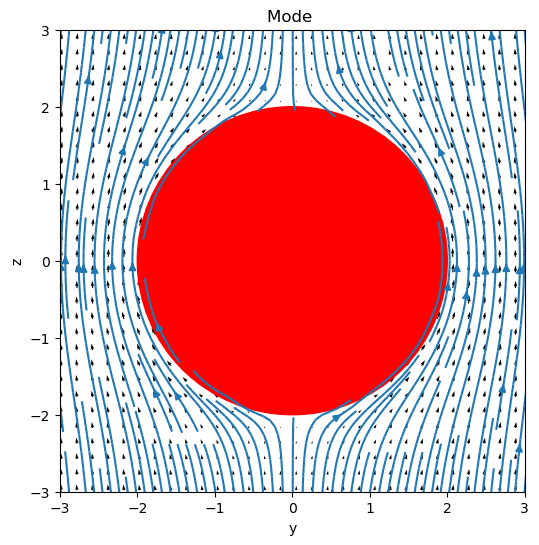

In [54]:
circle1 = plt.Circle((0, 0), 2, color='r')

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

skip = (slice(None, None, 2), slice(None, None, 2))
plt.quiver(Z[skip], Y[skip], u_z[skip], u_y[skip], )
ax.streamplot(Z[skip], Y[skip], u_z[skip], u_y[skip], density = 3)


ax.add_patch(circle1)

plt.xlabel("y")
plt.ylabel("z")
plt.title("Mode ")